In [1]:
from qiskit.utils import QuantumInstance
from qiskit import IBMQ, Aer
from main_v2 import *
import QuantumTomography as qt
from joblib import Parallel, delayed
import json
from time import time
%precision 6

'%.6f'

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-csic', group='internal', project='iff-csic')
backend  = provider.get_backend('ibm_lagos')
noise_model = NoiseModel.from_backend(backend)
# noise_model = decoherence_noise(T1=5e3, T2=200e3)
# quantum_instance = QuantumInstance( Aer.get_backend('aer_simulator'), shots=2**13, noise_model=noise_model )
quantum_instance = QuantumInstance( backend, shots=2**13 )

In [3]:
import qiskit.tools.jupyter

In [4]:
backend

<IBMQBackend('ibm_lagos') from IBMQ(hub='ibm-q-csic', group='internal', project='iff-csic')>

In [5]:
dpmt = device_process_measurement_tomography( backend )

In [6]:
circs_pkg = dpmt.circuits()

In [7]:
# job1 = backend.retrieve_job('6166be8bab11301434044f70')
# job2 = backend.retrieve_job('6166be8ebe575d5acd713a88')
job1 = backend.retrieve_job('616f5990cea63358bd144f6c')
job2 = backend.retrieve_job('616f5997dd30e90910e61666')

In [8]:
readout_error, T1 = get_noise( job1 )

In [9]:
results_1 = job1.result()
results_2 = job2.result()
results   = [results_1,results_2]

In [10]:
mc = 8

In [11]:
def fun():
    choi_single, choi_double, gateset  = dpmt.fit( results, resampling=2**10, paralell=False )
    parall_qubits = dpmt._parall_qubits
    num_qubits = dpmt._num_qubits
    
    quantities = []
    for k in range(num_qubits):
        quantities.append( Quantities( choi_single[k][0], choi_single[k][1] ) )
    
    quantities_2 = []
    cros_quantities = []
    for i in range(len(parall_qubits)):
        for j in range(len(parall_qubits[i])):
            k = parall_qubits[i][j][0]
            l = parall_qubits[i][j][1]
            cros_quantities.append( Cross_Quantities( choi_single[k][0], choi_single[k][1],
                                                      choi_single[l][0], choi_single[l][1],
                                                      choi_double[i][j][0], choi_double[i][j][1]
                                                    )  )
            quantities_2.append( Quantities( choi_double[i][j][0], choi_double[i][j][1] ) )
    
    return quantities, quantities_2, cros_quantities

In [12]:
t1 = time()
datos = Parallel(n_jobs=-1)( delayed( fun )() for _ in range(mc) ) 
t2 = time()
print(t2-t1)

302.024685382843


In [13]:
np.save( 'datos_montecarlo', np.array( datos, dtype=object ) )

In [14]:
q1s = []
q2s = []
q3s = []
for d in datos:
    q1s.append( d[0] )
    q2s.append( d[1] )
    q3s.append( d[2] ) 

In [15]:
q1_mean = np.mean( q1s, axis=0 )
q1_std  = np.std( q1s, axis=0 )
q2_mean = np.mean( q2s, axis=0 )
q2_std  = np.std( q2s, axis=0 )
q3_mean = np.mean( q3s, axis=0 )
q3_std  = np.std( q3s, axis=0 )

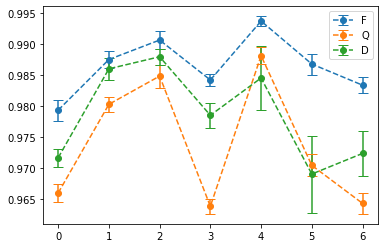

In [16]:
for k in range(3):
    plt.errorbar( x=range(7), y=q1_mean[:,k], yerr=q1_std[:,k], capsize=5, fmt='--o' )
plt.legend( ['F','Q', 'D'] )

In [17]:
readout_error

[0.006800, 0.012600, 0.008800, 0.012200, 0.008900, 0.033900, 0.006800]

In [18]:
T1

[0.000113, 0.000112, 0.000183, 0.000237, 0.000101, 0.000065, 0.000179]

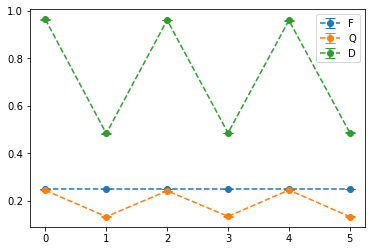

In [19]:
for k in range(3):
    plt.errorbar( x=range(6), y=q2_mean[:,k], yerr=q2_std[:,k], capsize=5, fmt='--o' )
plt.legend( ['F','Q', 'D'] )

In [20]:
q2_mean

array([[0.25    , 0.243589, 0.964161],
       [0.25    , 0.133083, 0.483588],
       [0.25    , 0.241603, 0.961965],
       [0.25    , 0.134215, 0.485606],
       [0.25    , 0.244876, 0.960609],
       [0.25    , 0.132761, 0.486831]])

In [21]:
q2_std

array([[1.395805e-15, 3.326154e-04, 1.049793e-03],
       [1.132380e-15, 6.472247e-04, 1.053539e-03],
       [1.069941e-15, 3.141615e-04, 7.894084e-04],
       [1.759034e-15, 9.653615e-04, 7.608527e-04],
       [1.409262e-15, 5.877745e-04, 1.280822e-03],
       [1.826709e-15, 9.954750e-04, 8.614826e-04]])

In [22]:
parall_qubits

NameError: name 'parall_qubits' is not defined

In [ ]:
for k in range(2):
    plt.errorbar( x=range(6), y=q3_mean[:,k], yerr=q3_std[:,k], capsize=5, fmt='--o' )
plt.legend( ['cF','cQ'] )

In [ ]:
parall_qubits